In [1]:
# Parameters (overridden during execution)
EPOCHS = 30
RUN_ID = 1
OUT_DIR = "/kaggle/working/outputs"

In [5]:
import os
import math
import time
import random
import multiprocessing
from datetime import timedelta
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from timm.models.vision_transformer import VisionTransformer, PatchEmbed
from torchinfo import summary
from torchview import draw_graph

In [3]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
from collections import Counter

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [13]:
# -------------------------
# Config (dynamic params)
# -------------------------
BATCH_SIZE = 6
IMG_SIZE   = 224

# -------------------------
# Load data
# -------------------------
# data = np.load("/kaggle/input/pneumoniamnist.npz")
''''''




''

In [14]:
train_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)


print(train_df.shape)
train_df.head()


(30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [15]:
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)

print("Raw rows:", len(train_df))
print("Unique images:", len(df))

Raw rows: 30227
Unique images: 26684


In [16]:
from sklearn.model_selection import train_test_split

# First split: Train vs Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

# Second split: Val vs Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (18678, 2)
Val: (4003, 2)
Test: (4003, 2)


In [17]:
import os
import pydicom
import numpy as np
import random

TRAIN_IMG_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

In [17]:
def show_random_images_per_class(
    dataset,
    class_names,
    n_per_class=5,
    seed=42,
    image_names=None
):
    """
    Displays n random images per class in an m x n grid.
    If image_names is None, uses ClassName_index.
    """

    random.seed(seed)
    torch.manual_seed(seed)

    labels = dataset.labels.cpu().numpy()
    images = dataset.images.cpu()
    num_classes = len(class_names)

    class_indices = [
        np.where(labels == c)[0]
        for c in range(num_classes)
    ]

    fig, axes = plt.subplots(
        num_classes,
        n_per_class,
        figsize=(3 * n_per_class, 3 * num_classes),
        squeeze=False
    )

    for cls in range(num_classes):
        idxs = class_indices[cls]
        k = min(n_per_class, len(idxs))
        selected = np.random.choice(idxs, size=k, replace=False)

        for col, idx in enumerate(selected):
            img = images[idx].permute(1, 2, 0).numpy()
            img = img / 255.0  # correct float range for imshow

            ax = axes[cls, col]
            ax.imshow(img)
            ax.axis("off")

            # Image title
            if image_names is not None:
                title = image_names[idx]
            else:
                title = f"{class_names[cls]}_{idx}"

            ax.set_title(title, fontsize=9)

            if col == 0:
                ax.set_ylabel(
                    class_names[cls],
                    rotation=90,
                    fontsize=12,
                    labelpad=10
                )

    plt.tight_layout()
    plt.show()

class_names = ["Normal", "Pneumonia"]

show_random_images_per_class(
    train_dataset,
    class_names=class_names,
    n_per_class=5
)

NameError: name 'train_dataset' is not defined

In [19]:
import os
import torch
import pydicom
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [20]:
class RSNAPneumoniaDataset(Dataset):
    def __init__(self, df, image_dir, img_size):
        """
        df: DataFrame with columns ['patientId', 'label']
        image_dir: directory containing .dcm files
        img_size: target image size (e.g., 224)
        """
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def load_dicom(self, path):
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)

        # Normalize per image (important for RSNA)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        return img

    def __getitem__(self, idx):
        patient_id = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]

        dcm_path = os.path.join(self.image_dir, f"{patient_id}.dcm")

        # Load image
        img = self.load_dicom(dcm_path)

        # (H, W) → (1, H, W)
        img = torch.from_numpy(img).unsqueeze(0)

        # Grayscale → RGB
        img = img.repeat(3, 1, 1)   # (3, H, W)

        # Resize
        img = F.interpolate(
            img.unsqueeze(0),
            size=(self.img_size, self.img_size),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        return img, torch.tensor(label, dtype=torch.long)


In [21]:
IMAGE_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
IMG_SIZE = 224
BATCH_SIZE = 6


In [22]:
import cv2

In [23]:
class TwoMaxMinusMinPool2d(nn.Module):
    """
    Pooling layer that computes:
        output = (2 * max_pool) - min_pool

    Uses only optimized max-pooling kernels.
    Computational cost ~ 2× max pooling.
    Output shape matches standard pooling.
    """

    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()

        # Match PyTorch pooling semantics
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, x):
        # Fast max pooling (optimized C++/CUDA)
        max_pool = F.max_pool2d(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Fast min pooling via negation trick
        min_pool = -F.max_pool2d(
            -x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Final contrast-enhanced response
        return (2.0 * max_pool) - min_pool

In [23]:
train_dataset = RSNAPneumoniaDataset(train_df, IMAGE_DIR, IMG_SIZE)
val_dataset   = RSNAPneumoniaDataset(val_df,   IMAGE_DIR, IMG_SIZE)
test_dataset  = RSNAPneumoniaDataset(test_df,  IMAGE_DIR, IMG_SIZE)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


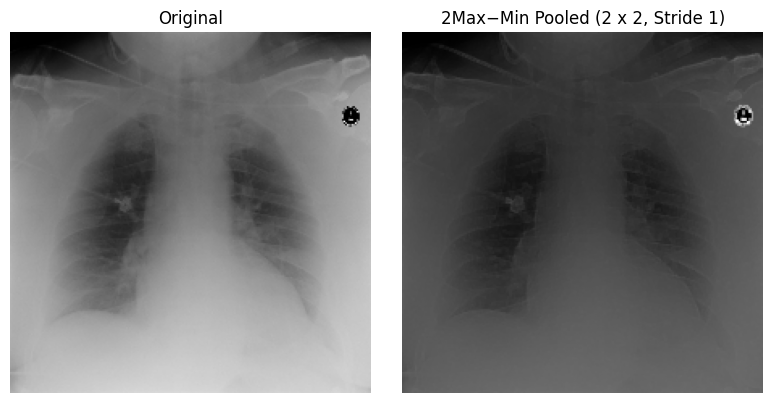

In [25]:
KERNEL_SIZE = 2
STRIDE = 1

# Get one batch
images, labels = next(iter(train_loader))

# Take first image only
img = images[0:1]  # shape: (1, C, H, W)

pool = TwoMaxMinusMinPool2d(kernel_size=KERNEL_SIZE, stride=STRIDE)
pool.eval()

with torch.no_grad():
    pooled = pool(img)

# Convert to numpy for display
img_np = img[0].cpu().numpy()
pooled_np = pooled[0].cpu().numpy()

# Pick one channel to visualize
ch = 0

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(img_np[ch], cmap="gray")
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(pooled_np[ch], cmap="gray")
axs[1].set_title(F"2Max−Min Pooled ({KERNEL_SIZE} x {KERNEL_SIZE}, Stride {STRIDE})")
axs[1].axis("off")

plt.tight_layout()
plt.show()

In [24]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from timm.models.vision_transformer import VisionTransformer


class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # --------------------------------------------------
        # MobileNetV2 backbone
        # --------------------------------------------------
        pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        num_blocks = len(pretrained_model.features)

        # Freeze first half
        for p in pretrained_model.features[:num_blocks // 2].parameters():
            p.requires_grad = False

        self.mobilenet_feature_blocks_1 = nn.Sequential(
            *pretrained_model.features[:num_blocks - 3]
        )
        self.mobilenet_block_2nd_last = pretrained_model.features[num_blocks - 3]  # 160
        self.mobilenet_block_mid = pretrained_model.features[num_blocks - 2]       # 320
        self.mobilenet_block_last = pretrained_model.features[num_blocks - 1]      # 1280

        # --------------------------------------------------
        # CNN branch → 128
        # --------------------------------------------------
        self.cnn_proj = nn.Sequential(
            nn.Conv2d(1280, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))   # NO max–min pooling
        )

        # --------------------------------------------------
        # CNN → ViT adapter (unchanged)
        # --------------------------------------------------
        self.cnn_to_vit_adapter = nn.Sequential(
            nn.Conv2d(320, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(14, 14), mode="bilinear", align_corners=False),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False),

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),

            nn.Upsample(size=(56, 56), mode="bilinear", align_corners=False),
        )

        # --------------------------------------------------
        # ViT-1 (64)
        # --------------------------------------------------
        self.vit_encoder1 = VisionTransformer(
            img_size=56,
            patch_size=8,
            in_chans=16,
            num_classes=0,
            embed_dim=64,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder1.head = nn.Identity()

        self.vit_encoder1.patch_embed.proj = nn.Conv2d(
            16, 64, kernel_size=8, stride=4, bias=True
        )

        self.vit_encoder1.pos_embed = nn.Parameter(
            torch.zeros(1, 170, 64)   # 13×13 + CLS
        )
        nn.init.trunc_normal_(self.vit_encoder1.pos_embed, std=0.02)

        # --------------------------------------------------
        # ViT-2 (64)
        # --------------------------------------------------
        self.vit_encoder2 = VisionTransformer(
            img_size=56,
            patch_size=8,
            in_chans=16,
            num_classes=0,
            embed_dim=64,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder2.head = nn.Identity()

        self.vit_encoder2.patch_embed.proj = nn.Conv2d(
            16, 64, kernel_size=8, stride=4, bias=True
        )

        self.vit_encoder2.pos_embed = nn.Parameter(
            torch.zeros(1, 170, 64)
        )
        nn.init.trunc_normal_(self.vit_encoder2.pos_embed, std=0.02)

        # --------------------------------------------------
        # Classifier → (128 + 64 + 64 = 256)
        # --------------------------------------------------
        self.classifier_head = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.mobilenet_feature_blocks_1(x)
        x_2nd_last = self.mobilenet_block_2nd_last(x)
        x_mid = self.mobilenet_block_mid(x_2nd_last)
        x_last = self.mobilenet_block_last(x_mid)

        # CNN branch
        cnn_feat = self.cnn_proj(x_last).flatten(1)   # (B, 128)

        # ViT branches
        vit_input = self.cnn_to_vit_adapter(x_mid)    # (B, 16, 56, 56)

        vit1_feat = self.vit_encoder1(vit_input)      # (B, 64)
        vit2_feat = self.vit_encoder2(vit_input)      # (B, 64)

        # Fusion
        combined = torch.cat([cnn_feat, vit1_feat, vit2_feat], dim=1)

        return self.classifier_head(combined)


In [25]:
model = CNN_ViT_Model(num_classes=2)
summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 114MB/s] 


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
CNN_ViT_Model                                      [1, 3, 224, 224]          [1, 2]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 160, 7, 7]            --                        Partial
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                      

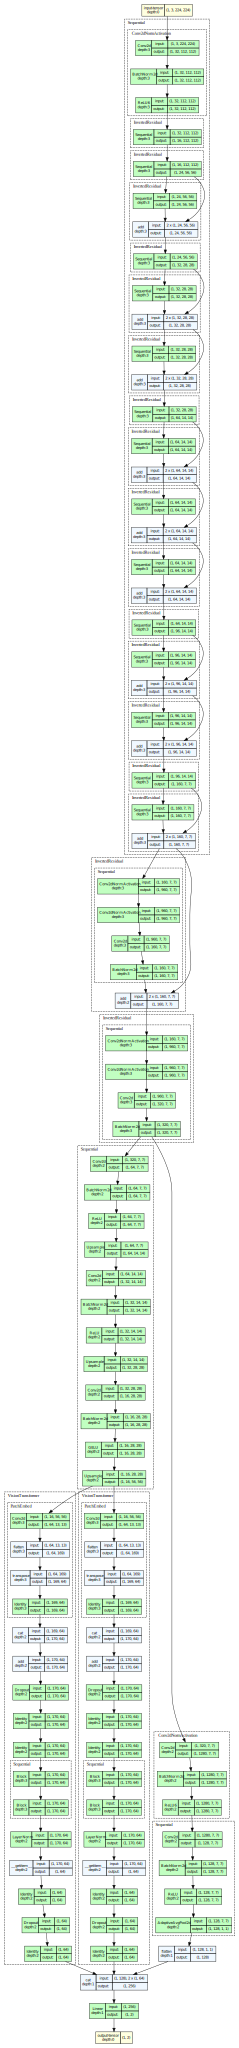

In [26]:
model.to(device)

# Dummy input (can adjust shape based on your model's expected input)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Generate the graph — expand_nested=True if model has nested submodules
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="CNN_ViT_Model",
    save_graph=False  # We don't want to save, only display inline
)

# Render to SVG and display inline in the notebook
svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [27]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()

        # Skip AUC if only one class is present
        if np.unique(class_y_true).size < 2:
            continue
        try:
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        except ValueError:
            continue

    auc_avg = np.mean(auc_scores) if auc_scores else 0.0

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [29]:
# Hyperparameters
num_epochs       = EPOCHS
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [30]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric: [] for metric in metric_names}
val_metrics_history = {metric: [] for metric in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training loop
    model.train()
    total_train_loss = 0.0
    all_train_predictions = []
    all_train_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        all_train_predictions.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_train_loss = total_train_loss / len(train_loader)
    all_train_predictions = np.array(all_train_predictions)
    all_train_targets = np.array(all_train_targets)

    train_metrics = custom_metrics(torch.tensor(all_train_predictions), torch.tensor(all_train_targets), average_train_loss)
    training_metrics_line = "Train Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(training_metrics_line)

    for metric in metric_names:
        train_metrics_history[metric].append(train_metrics[metric])

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    all_val_predictions = []
    all_val_targets = []
    start_val_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            all_val_predictions.extend(outputs.detach().cpu().numpy())
            all_val_targets.extend(targets.detach().cpu().numpy())

    end_val_time = time.time()
    epoch_validation_time = end_val_time - start_val_time
    total_validation_time += epoch_validation_time

    average_val_loss = total_val_loss / len(val_loader)
    all_val_predictions = np.array(all_val_predictions)
    all_val_targets = np.array(all_val_targets)

    val_metrics = custom_metrics(torch.tensor(all_val_predictions), torch.tensor(all_val_targets), average_val_loss)
    validation_metrics_line = "Val Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(validation_metrics_line)

    for metric in metric_names:
        val_metrics_history[metric].append(val_metrics[metric])

    # Update LR via scheduler rather than manual mutliplication
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.4f} — LR: {current_lr:.6f}")

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / (epoch + 1)
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Epoch [1/30]: 100%|██████████| 3113/3113 [04:11<00:00, 12.36it/s]


Train Metrics - loss: 0.4082, accuracy: 0.8127, precision: 0.7955, recall: 0.8127, f1_score: 0.7966, specificity: 0.9321, sensitivity: 0.4021, mcc: 0.3987, auc: 0.8182


Validating Model: 100%|██████████| 668/668 [00:53<00:00, 12.40it/s]


Val Metrics - loss: 0.3818, accuracy: 0.8259, precision: 0.8166, recall: 0.8259, f1_score: 0.7984, specificity: 0.9694, sensitivity: 0.3326, mcc: 0.4230, auc: 0.8580
Epoch 0/30 — Loss: 0.1674 — LR: 0.000100


Training Epoch [2/30]: 100%|██████████| 3113/3113 [03:00<00:00, 17.25it/s]


Train Metrics - loss: 0.3670, accuracy: 0.8386, precision: 0.8289, recall: 0.8386, f1_score: 0.8307, specificity: 0.9296, sensitivity: 0.5259, mcc: 0.5030, auc: 0.8548


Validating Model: 100%|██████████| 668/668 [00:37<00:00, 17.95it/s]


Val Metrics - loss: 0.3664, accuracy: 0.8354, precision: 0.8246, recall: 0.8354, f1_score: 0.8260, specificity: 0.9316, sensitivity: 0.5044, mcc: 0.4889, auc: 0.8596
Epoch 1/30 — Loss: 0.2645 — LR: 0.000100


Training Epoch [3/30]: 100%|██████████| 3113/3113 [03:02<00:00, 17.06it/s]


Train Metrics - loss: 0.3379, accuracy: 0.8546, precision: 0.8476, recall: 0.8546, f1_score: 0.8491, specificity: 0.9331, sensitivity: 0.5846, mcc: 0.5587, auc: 0.8722


Validating Model: 100%|██████████| 668/668 [00:36<00:00, 18.10it/s]


Val Metrics - loss: 0.3734, accuracy: 0.8296, precision: 0.8177, recall: 0.8296, f1_score: 0.8194, specificity: 0.9297, sensitivity: 0.4856, mcc: 0.4687, auc: 0.8607
Epoch 2/30 — Loss: 0.8033 — LR: 0.000100


Training Epoch [4/30]: 100%|██████████| 3113/3113 [02:58<00:00, 17.41it/s]


Train Metrics - loss: 0.2850, accuracy: 0.8779, precision: 0.8740, recall: 0.8779, f1_score: 0.8751, specificity: 0.9386, sensitivity: 0.6694, mcc: 0.6369, auc: 0.9222


Validating Model: 100%|██████████| 668/668 [00:36<00:00, 18.21it/s]


Val Metrics - loss: 0.3987, accuracy: 0.8294, precision: 0.8176, recall: 0.8294, f1_score: 0.8194, specificity: 0.9287, sensitivity: 0.4878, mcc: 0.4687, auc: 0.8523
Epoch 3/30 — Loss: 0.1137 — LR: 0.000100


Training Epoch [5/30]: 100%|██████████| 3113/3113 [02:59<00:00, 17.37it/s]


Train Metrics - loss: 0.2191, accuracy: 0.9109, precision: 0.9094, recall: 0.9109, f1_score: 0.9099, specificity: 0.9514, sensitivity: 0.7716, mcc: 0.7397, auc: 0.9554


Validating Model: 100%|██████████| 668/668 [00:36<00:00, 18.21it/s]


Val Metrics - loss: 0.4583, accuracy: 0.8044, precision: 0.8098, recall: 0.8044, f1_score: 0.8068, specificity: 0.8629, sensitivity: 0.6031, mcc: 0.4546, auc: 0.8416
Epoch 4/30 — Loss: 2.5021 — LR: 0.000100


Training Epoch [6/30]: 100%|██████████| 3113/3113 [02:59<00:00, 17.31it/s]


Train Metrics - loss: 0.1695, accuracy: 0.9340, precision: 0.9333, recall: 0.9340, f1_score: 0.9335, specificity: 0.9634, sensitivity: 0.8329, mcc: 0.8085, auc: 0.9726


Validating Model: 100%|██████████| 668/668 [00:36<00:00, 18.37it/s]


Val Metrics - loss: 0.5467, accuracy: 0.8251, precision: 0.8184, recall: 0.8251, f1_score: 0.8210, specificity: 0.9049, sensitivity: 0.5510, mcc: 0.4781, auc: 0.8363
Epoch 5/30 — Loss: 0.9119 — LR: 0.000100


Training Epoch [7/30]: 100%|██████████| 3113/3113 [02:59<00:00, 17.34it/s]


Train Metrics - loss: 0.1254, accuracy: 0.9511, precision: 0.9507, recall: 0.9511, f1_score: 0.9508, specificity: 0.9721, sensitivity: 0.8788, mcc: 0.8587, auc: 0.9852


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.73it/s]


Val Metrics - loss: 0.6269, accuracy: 0.7987, precision: 0.7923, recall: 0.7987, f1_score: 0.7951, specificity: 0.8836, sensitivity: 0.5067, mcc: 0.4043, auc: 0.8027
Epoch 6/30 — Loss: 3.3665 — LR: 0.000100


Training Epoch [8/30]: 100%|██████████| 3113/3113 [02:52<00:00, 18.05it/s]


Train Metrics - loss: 0.0999, accuracy: 0.9605, precision: 0.9604, recall: 0.9605, f1_score: 0.9605, specificity: 0.9762, sensitivity: 0.9068, mcc: 0.8865, auc: 0.9905


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.70it/s]


Val Metrics - loss: 0.6128, accuracy: 0.7987, precision: 0.7904, recall: 0.7987, f1_score: 0.7938, specificity: 0.8881, sensitivity: 0.4911, mcc: 0.3981, auc: 0.8075
Epoch 7/30 — Loss: 4.0956 — LR: 0.000100


Training Epoch [9/30]: 100%|██████████| 3113/3113 [02:49<00:00, 18.37it/s]


Train Metrics - loss: 0.0831, accuracy: 0.9691, precision: 0.9691, recall: 0.9691, f1_score: 0.9691, specificity: 0.9808, sensitivity: 0.9289, mcc: 0.9114, auc: 0.9936


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.96it/s]


Val Metrics - loss: 0.7087, accuracy: 0.7997, precision: 0.8085, recall: 0.7997, f1_score: 0.8035, specificity: 0.8536, sensitivity: 0.6142, mcc: 0.4503, auc: 0.8271
Epoch 8/30 — Loss: 5.1759 — LR: 0.000100


Training Epoch [10/30]: 100%|██████████| 3113/3113 [02:48<00:00, 18.49it/s]


Train Metrics - loss: 0.0761, accuracy: 0.9710, precision: 0.9709, recall: 0.9710, f1_score: 0.9710, specificity: 0.9832, sensitivity: 0.9292, mcc: 0.9167, auc: 0.9946


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.56it/s]


Val Metrics - loss: 0.7564, accuracy: 0.7972, precision: 0.7978, recall: 0.7972, f1_score: 0.7975, specificity: 0.8678, sensitivity: 0.5543, mcc: 0.4208, auc: 0.8132
Epoch 9/30 — Loss: 6.8585 — LR: 0.000100


Training Epoch [11/30]: 100%|██████████| 3113/3113 [02:46<00:00, 18.71it/s]


Train Metrics - loss: 0.0637, accuracy: 0.9774, precision: 0.9773, recall: 0.9774, f1_score: 0.9773, specificity: 0.9861, sensitivity: 0.9472, mcc: 0.9350, auc: 0.9960


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.83it/s]


Val Metrics - loss: 0.7727, accuracy: 0.7967, precision: 0.7944, recall: 0.7967, f1_score: 0.7955, specificity: 0.8733, sensitivity: 0.5333, mcc: 0.4111, auc: 0.8176
Epoch 10/30 — Loss: 2.6676 — LR: 0.000097


Training Epoch [12/30]: 100%|██████████| 3113/3113 [02:46<00:00, 18.72it/s]


Train Metrics - loss: 0.0611, accuracy: 0.9780, precision: 0.9779, recall: 0.9780, f1_score: 0.9780, specificity: 0.9868, sensitivity: 0.9477, mcc: 0.9368, auc: 0.9962


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 20.04it/s]


Val Metrics - loss: 0.7558, accuracy: 0.8121, precision: 0.8044, recall: 0.8121, f1_score: 0.8075, specificity: 0.8971, sensitivity: 0.5200, mcc: 0.4383, auc: 0.8240
Epoch 11/30 — Loss: 4.7015 — LR: 0.000094


Training Epoch [13/30]: 100%|██████████| 3113/3113 [02:44<00:00, 18.96it/s]


Train Metrics - loss: 0.0541, accuracy: 0.9798, precision: 0.9798, recall: 0.9798, f1_score: 0.9798, specificity: 0.9883, sensitivity: 0.9506, mcc: 0.9420, auc: 0.9972


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 20.00it/s]


Val Metrics - loss: 0.9415, accuracy: 0.8174, precision: 0.8025, recall: 0.8174, f1_score: 0.8045, specificity: 0.9274, sensitivity: 0.4390, mcc: 0.4229, auc: 0.7971
Epoch 12/30 — Loss: 4.0517 — LR: 0.000091


Training Epoch [14/30]: 100%|██████████| 3113/3113 [02:42<00:00, 19.12it/s]


Train Metrics - loss: 0.0458, accuracy: 0.9838, precision: 0.9838, recall: 0.9838, f1_score: 0.9838, specificity: 0.9911, sensitivity: 0.9589, mcc: 0.9535, auc: 0.9978


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.87it/s]


Val Metrics - loss: 0.8054, accuracy: 0.8224, precision: 0.8105, recall: 0.8224, f1_score: 0.8133, specificity: 0.9200, sensitivity: 0.4867, mcc: 0.4507, auc: 0.8313
Epoch 13/30 — Loss: 3.0485 — LR: 0.000089


Training Epoch [15/30]: 100%|██████████| 3113/3113 [02:44<00:00, 18.91it/s]


Train Metrics - loss: 0.0385, accuracy: 0.9860, precision: 0.9860, recall: 0.9860, f1_score: 0.9860, specificity: 0.9914, sensitivity: 0.9674, mcc: 0.9598, auc: 0.9985


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 20.24it/s]


Val Metrics - loss: 0.8400, accuracy: 0.8116, precision: 0.8145, recall: 0.8116, f1_score: 0.8130, specificity: 0.8723, sensitivity: 0.6031, mcc: 0.4686, auc: 0.8196
Epoch 14/30 — Loss: 4.6437 — LR: 0.000086


Training Epoch [16/30]: 100%|██████████| 3113/3113 [02:42<00:00, 19.19it/s]


Train Metrics - loss: 0.0369, accuracy: 0.9873, precision: 0.9873, recall: 0.9873, f1_score: 0.9873, specificity: 0.9920, sensitivity: 0.9710, mcc: 0.9635, auc: 0.9984


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.42it/s]


Val Metrics - loss: 0.9250, accuracy: 0.8159, precision: 0.8032, recall: 0.8159, f1_score: 0.8065, specificity: 0.9158, sensitivity: 0.4723, mcc: 0.4301, auc: 0.8123
Epoch 15/30 — Loss: 0.0451 — LR: 0.000083


Training Epoch [17/30]: 100%|██████████| 3113/3113 [02:44<00:00, 18.94it/s]


Train Metrics - loss: 0.0371, accuracy: 0.9868, precision: 0.9868, recall: 0.9868, f1_score: 0.9868, specificity: 0.9921, sensitivity: 0.9686, mcc: 0.9621, auc: 0.9985


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.15it/s]


Val Metrics - loss: 0.8205, accuracy: 0.8039, precision: 0.7981, recall: 0.8039, f1_score: 0.8006, specificity: 0.8862, sensitivity: 0.5211, mcc: 0.4210, auc: 0.8197
Epoch 16/30 — Loss: 3.6755 — LR: 0.000081


Training Epoch [18/30]: 100%|██████████| 3113/3113 [02:44<00:00, 18.92it/s]


Train Metrics - loss: 0.0314, accuracy: 0.9885, precision: 0.9885, recall: 0.9885, f1_score: 0.9885, specificity: 0.9928, sensitivity: 0.9736, mcc: 0.9670, auc: 0.9991


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.53it/s]


Val Metrics - loss: 0.9149, accuracy: 0.8146, precision: 0.8003, recall: 0.8146, f1_score: 0.8033, specificity: 0.9207, sensitivity: 0.4501, mcc: 0.4195, auc: 0.8100
Epoch 17/30 — Loss: 4.2041 — LR: 0.000078


Training Epoch [19/30]: 100%|██████████| 3113/3113 [02:45<00:00, 18.85it/s]


Train Metrics - loss: 0.0294, accuracy: 0.9892, precision: 0.9892, recall: 0.9892, f1_score: 0.9892, specificity: 0.9938, sensitivity: 0.9734, mcc: 0.9691, auc: 0.9991


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.95it/s]


Val Metrics - loss: 0.9100, accuracy: 0.8116, precision: 0.8050, recall: 0.8116, f1_score: 0.8078, specificity: 0.8939, sensitivity: 0.5288, mcc: 0.4404, auc: 0.8300
Epoch 18/30 — Loss: 5.1710 — LR: 0.000076


Training Epoch [20/30]: 100%|██████████| 3113/3113 [02:41<00:00, 19.24it/s]


Train Metrics - loss: 0.0253, accuracy: 0.9913, precision: 0.9913, recall: 0.9913, f1_score: 0.9913, specificity: 0.9943, sensitivity: 0.9810, mcc: 0.9750, auc: 0.9994


Validating Model: 100%|██████████| 668/668 [00:32<00:00, 20.26it/s]


Val Metrics - loss: 0.9094, accuracy: 0.8229, precision: 0.8123, recall: 0.8229, f1_score: 0.8153, specificity: 0.9155, sensitivity: 0.5044, mcc: 0.4576, auc: 0.8232
Epoch 19/30 — Loss: 7.5232 — LR: 0.000074


Training Epoch [21/30]: 100%|██████████| 3113/3113 [02:43<00:00, 19.05it/s]


Train Metrics - loss: 0.0217, accuracy: 0.9924, precision: 0.9924, recall: 0.9924, f1_score: 0.9924, specificity: 0.9954, sensitivity: 0.9822, mcc: 0.9782, auc: 0.9995


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.58it/s]


Val Metrics - loss: 1.0621, accuracy: 0.7897, precision: 0.7972, recall: 0.7897, f1_score: 0.7930, specificity: 0.8500, sensitivity: 0.5820, mcc: 0.4184, auc: 0.7989
Epoch 20/30 — Loss: 7.3005 — LR: 0.000072


Training Epoch [22/30]: 100%|██████████| 3113/3113 [02:43<00:00, 19.01it/s]


Train Metrics - loss: 0.0239, accuracy: 0.9909, precision: 0.9909, recall: 0.9909, f1_score: 0.9909, specificity: 0.9944, sensitivity: 0.9788, mcc: 0.9739, auc: 0.9994


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.89it/s]


Val Metrics - loss: 0.9068, accuracy: 0.8209, precision: 0.8171, recall: 0.8209, f1_score: 0.8188, specificity: 0.8936, sensitivity: 0.5710, mcc: 0.4756, auc: 0.8303
Epoch 21/30 — Loss: 4.9181 — LR: 0.000069


Training Epoch [23/30]: 100%|██████████| 3113/3113 [02:43<00:00, 19.06it/s]


Train Metrics - loss: 0.0215, accuracy: 0.9920, precision: 0.9920, recall: 0.9920, f1_score: 0.9920, specificity: 0.9952, sensitivity: 0.9808, mcc: 0.9770, auc: 0.9994


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 20.02it/s]


Val Metrics - loss: 0.9430, accuracy: 0.7957, precision: 0.8045, recall: 0.7957, f1_score: 0.7995, specificity: 0.8513, sensitivity: 0.6042, mcc: 0.4388, auc: 0.8153
Epoch 22/30 — Loss: 5.5807 — LR: 0.000067


Training Epoch [24/30]: 100%|██████████| 3113/3113 [02:42<00:00, 19.15it/s]


Train Metrics - loss: 0.0194, accuracy: 0.9930, precision: 0.9930, recall: 0.9930, f1_score: 0.9930, specificity: 0.9954, sensitivity: 0.9848, mcc: 0.9799, auc: 0.9996


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.81it/s]


Val Metrics - loss: 1.0580, accuracy: 0.8094, precision: 0.8016, recall: 0.8094, f1_score: 0.8047, specificity: 0.8952, sensitivity: 0.5144, mcc: 0.4302, auc: 0.8119
Epoch 23/30 — Loss: 6.2223 — LR: 0.000065


Training Epoch [25/30]: 100%|██████████| 3113/3113 [02:47<00:00, 18.59it/s]


Train Metrics - loss: 0.0212, accuracy: 0.9933, precision: 0.9933, recall: 0.9933, f1_score: 0.9933, specificity: 0.9955, sensitivity: 0.9855, mcc: 0.9807, auc: 0.9994


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.99it/s]


Val Metrics - loss: 1.0416, accuracy: 0.8076, precision: 0.8033, recall: 0.8076, f1_score: 0.8053, specificity: 0.8855, sensitivity: 0.5399, mcc: 0.4361, auc: 0.8000
Epoch 24/30 — Loss: 7.0750 — LR: 0.000063


Training Epoch [26/30]: 100%|██████████| 3113/3113 [02:44<00:00, 18.87it/s]


Train Metrics - loss: 0.0143, accuracy: 0.9946, precision: 0.9946, recall: 0.9946, f1_score: 0.9946, specificity: 0.9969, sensitivity: 0.9867, mcc: 0.9845, auc: 0.9998


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 20.02it/s]


Val Metrics - loss: 1.1174, accuracy: 0.8139, precision: 0.8010, recall: 0.8139, f1_score: 0.8045, specificity: 0.9142, sensitivity: 0.4690, mcc: 0.4241, auc: 0.7965
Epoch 25/30 — Loss: 7.9258 — LR: 0.000061


Training Epoch [27/30]: 100%|██████████| 3113/3113 [02:41<00:00, 19.24it/s]


Train Metrics - loss: 0.0133, accuracy: 0.9954, precision: 0.9954, recall: 0.9954, f1_score: 0.9954, specificity: 0.9973, sensitivity: 0.9891, mcc: 0.9870, auc: 0.9998


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.84it/s]


Val Metrics - loss: 1.1441, accuracy: 0.7952, precision: 0.8058, recall: 0.7952, f1_score: 0.7997, specificity: 0.8478, sensitivity: 0.6142, mcc: 0.4421, auc: 0.8131
Epoch 26/30 — Loss: 8.8907 — LR: 0.000060


Training Epoch [28/30]: 100%|██████████| 3113/3113 [02:46<00:00, 18.69it/s]


Train Metrics - loss: 0.0144, accuracy: 0.9949, precision: 0.9949, recall: 0.9949, f1_score: 0.9949, specificity: 0.9968, sensitivity: 0.9884, mcc: 0.9853, auc: 0.9998


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.74it/s]


Val Metrics - loss: 1.0733, accuracy: 0.8091, precision: 0.8087, recall: 0.8091, f1_score: 0.8089, specificity: 0.8778, sensitivity: 0.5732, mcc: 0.4520, auc: 0.8098
Epoch 27/30 — Loss: 9.6668 — LR: 0.000058


Training Epoch [29/30]: 100%|██████████| 3113/3113 [02:45<00:00, 18.86it/s]


Train Metrics - loss: 0.0132, accuracy: 0.9956, precision: 0.9956, recall: 0.9956, f1_score: 0.9956, specificity: 0.9975, sensitivity: 0.9888, mcc: 0.9873, auc: 0.9998


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.73it/s]


Val Metrics - loss: 1.0895, accuracy: 0.8049, precision: 0.8033, recall: 0.8049, f1_score: 0.8041, specificity: 0.8775, sensitivity: 0.5554, mcc: 0.4365, auc: 0.8084
Epoch 28/30 — Loss: 8.5468 — LR: 0.000056


Training Epoch [30/30]: 100%|██████████| 3113/3113 [02:44<00:00, 18.96it/s]


Train Metrics - loss: 0.0122, accuracy: 0.9957, precision: 0.9957, recall: 0.9957, f1_score: 0.9957, specificity: 0.9973, sensitivity: 0.9903, mcc: 0.9877, auc: 0.9998


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.90it/s]

Val Metrics - loss: 1.0977, accuracy: 0.8136, precision: 0.8054, recall: 0.8136, f1_score: 0.8086, specificity: 0.8997, sensitivity: 0.5177, mcc: 0.4408, auc: 0.8021
Epoch 29/30 — Loss: 6.6981 — LR: 0.000054
Total Training Time: 1:25:27.877444
Total Validation Time: 0:17:32.077915
Average Training Time per Epoch: 0:02:50.929248
Average Validation Time per Epoch: 0:00:35.069264


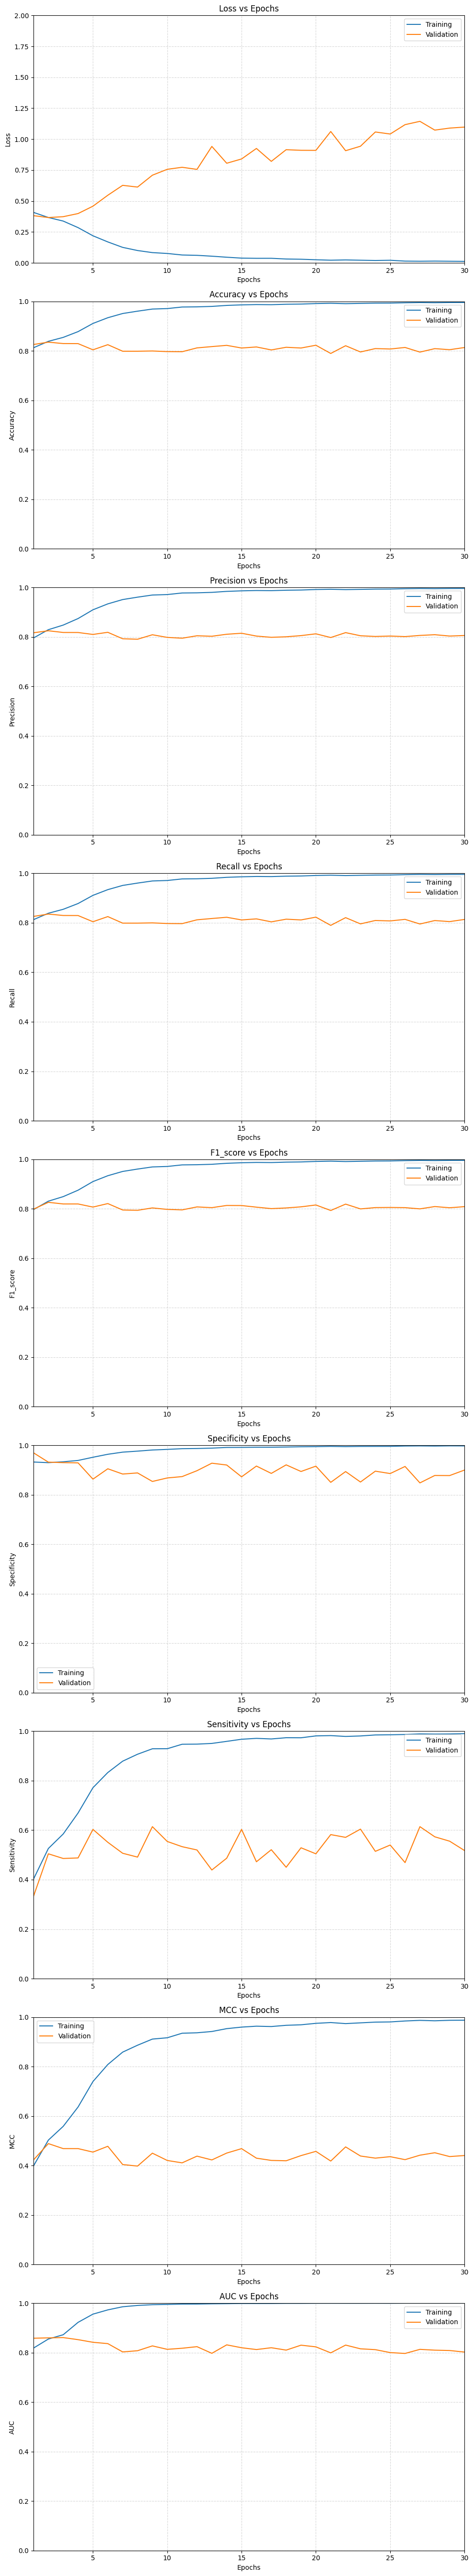

In [31]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(f"{metric_name.upper()} vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(f"{metric_name.capitalize()} vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        # Adjust xlim to avoid identical low and high limits.
        if num_epochs == 1:
            ax.set_xlim(0.5, 1.5)
        else:
            ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [32]:
# Testing loop
model.eval()
total_test_loss = 0.0
all_test_predictions = []
all_test_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_test_loss += loss.item()

        all_test_predictions.extend(outputs.detach().cpu().numpy())
        all_test_targets.extend(targets.detach().cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_targets = np.array(all_test_targets)

average_test_loss = total_test_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_test_predictions), torch.tensor(all_test_targets), average_test_loss)
testing_metrics_line = "Test Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
print(testing_metrics_line)

Testing Model: 100%|██████████| 668/668 [00:51<00:00, 13.09it/s]

Test Metrics - loss: 0.9881, accuracy: 0.8266, precision: 0.8198, recall: 0.8266, f1_score: 0.8224, specificity: 0.9062, sensitivity: 0.5532, mcc: 0.4822, auc: 0.8280


In [33]:
# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_test_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_test_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# # Option 2: if using ImageFolder
# classes = dataset.classes

# Class names in correct index order
class_name_map = {
    0: "Normal",
    1: "Pneumonia Present",
}
classes = [class_name_map[i] for i in sorted(class_name_map.keys())]

# Get class names from the dataset
# classes = train_dataset.classes

# classes = label_encoder.classes_

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                   precision    recall  f1-score   support

           Normal     0.8746    0.9062    0.8901      3101
Pneumonia Present     0.6316    0.5532    0.5898       902

         accuracy                         0.8266      4003
        macro avg     0.7531    0.7297    0.7400      4003
     weighted avg     0.8198    0.8266    0.8224      4003

There were 694 errors in 4003 tests for an accuracy of  82.66
